In [341]:
import snntorch as snn
import torch.nn as nn
from torchvision import datasets, transforms
from snntorch import utils, spikegen
from torch.utils.data import DataLoader, TensorDataset, Dataset
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
import matplotlib.pyplot as plt
import torch
import numpy as np
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


Data transform and download

In [328]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
class AddSaltPepperNoise(object):
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob
        
    def __call__(self, tensor):
        random_tensor = torch.rand(tensor.shape)
        salt_mask = random_tensor < self.salt_prob
        pepper_mask = (random_tensor > (1-self.pepper_prob)) 
        salt_pepper_noise = torch.zeros_like(tensor)
        salt_pepper_noise = salt_pepper_noise - pepper_mask.float() + salt_mask.float() 
        return tensor + salt_pepper_noise
    
    def __repr__(self):
        return self.__class__.__name__ + '(salt_prob={0}, pepper_prob={1})'.format(self.salt_prob, self.pepper_prob)

transform1 = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,),(1,)),
    transforms.RandomRotation([-10, 10])
])
transform2 = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,),(1,)),
    transforms.RandomRotation([-10, 10]),
    AddGaussianNoise(0,0.45)
])
transform3 = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,),(1,)),
    transforms.RandomRotation([-10, 10]),
    AddSaltPepperNoise(0.15, 0.15)
])

batch_size = 128
train_path = '/final_data/mnist/train'
test_path = '/final_data/mnist/test'
num_classes = 10
mnist_train_ = datasets.MNIST(train_path, train=True, download=True, transform=transform1)
mnist_test_ = datasets.MNIST(test_path, train=False, download=True, transform=transform1)

Take a subset of data to save time

In [329]:
subset = 5
mnist_train = utils.data_subset(mnist_train_, subset)
mnist_test = utils.data_subset(mnist_test_, subset)
print(mnist_train)
train_loader = DataLoader(mnist_train, batch_size = batch_size,shuffle=False)
test_loader = DataLoader(mnist_test, batch_size = batch_size,shuffle=False)
print(len(train_loader))
print(len(test_loader))

Dataset MNIST
    Number of datapoints: 12000
    Root location: /final_data/mnist/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0,), std=(1,))
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
           )
94
16


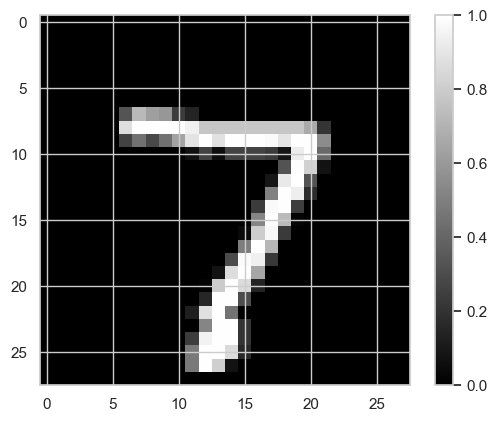

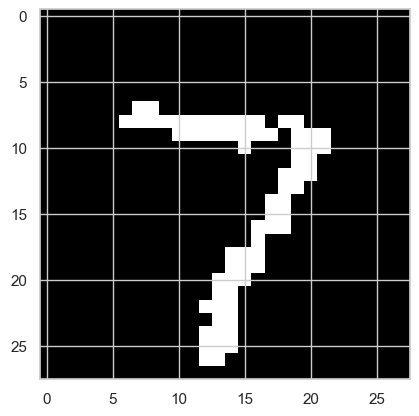

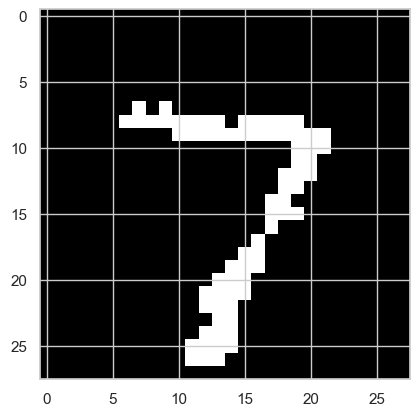

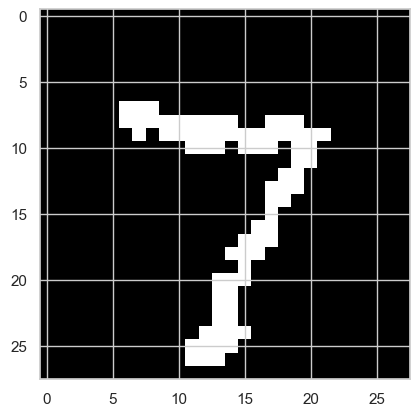

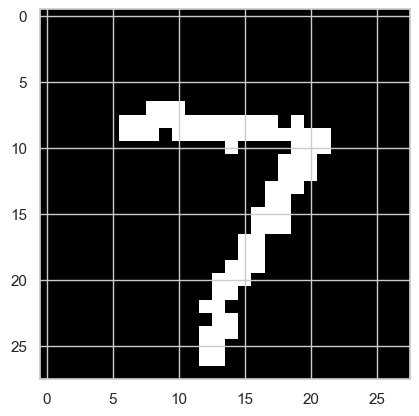

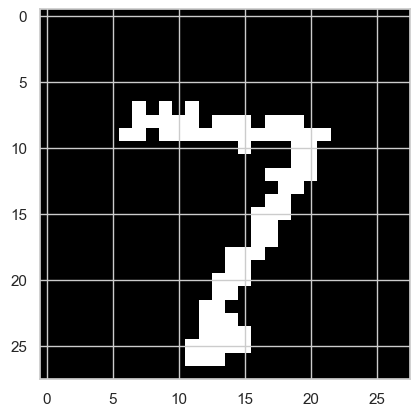

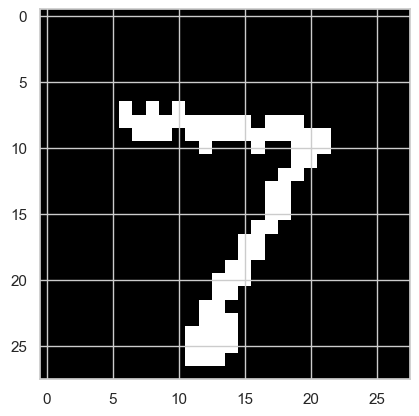

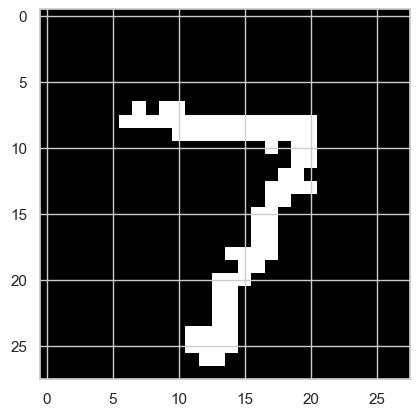

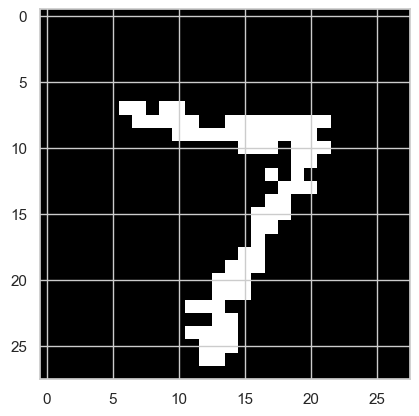

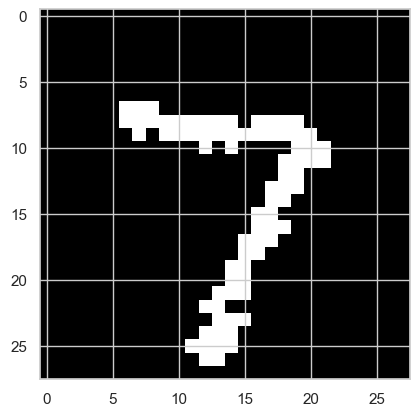

In [330]:
data, target = next(iter(test_loader))
train_spike_data = spikegen.rate(data,num_steps=num_steps)

plt.imshow(data[0][0], cmap='gray')
plt.colorbar()
plt.show()
for i in range(9):
    spike_image1 = train_spike_data[i][0][0]
    plt.imshow(spike_image1, cmap='gray')
    plt.show()


train a non-spiking cnn

In [331]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# reset the weight when needed. 
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [346]:
num_classes=10
learning_rate = 0.011
weight_decay = 0.05
num_epochs = 5
class ConvNeuralNet(nn.Module):
    def __init__(self,num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(12,32, 5)
        self.max_pool2 = nn.MaxPool2d(2)
        self.ft = nn.Flatten()
        self.relu1 = nn.ReLU()
        self.fc = nn.Linear(32*4*4, num_classes)
    def forward(self,x):
        out = self.conv1(x)
        out = self.max_pool1(out)
        out = self.conv2(out)
        out = self.max_pool2(out)
        out = self.ft(out)
        out = self.relu1(out)
        out = self.fc(out)
        return out

model = ConvNeuralNet(num_classes)
weight_reset(model)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
losses = []
acc = []
# optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
for epoch in range(num_epochs):
    total=0
    correct=0
    for i, (images, labels) in enumerate(iter(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
#         print(images.size())
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    acc.append(correct/total)
    losses.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1,num_epochs, loss.item()))

Epoch [1/5], Loss: 0.0954
Epoch [2/5], Loss: 0.0663
Epoch [3/5], Loss: 0.1088
Epoch [4/5], Loss: 0.0494
Epoch [5/5], Loss: 0.0325


In [347]:
# testing with CNN
with torch.no_grad():
    correct = 0
    total = 0
    for i, (data, label) in enumerate(iter(test_loader)):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        _, predicted = torch.max(output.data,1)
        total += label.size(0)
        correct += (predicted==label).sum().item()
    print('Accuracy of the network on the {} train images: {}%'.format(12000, 100*correct/total))
    test_acc_cnn=correct/total

Accuracy of the network on the 12000 train images: 96.1%


[0.8813333333333333, 0.96125, 0.9635, 0.9693333333333334, 0.975]


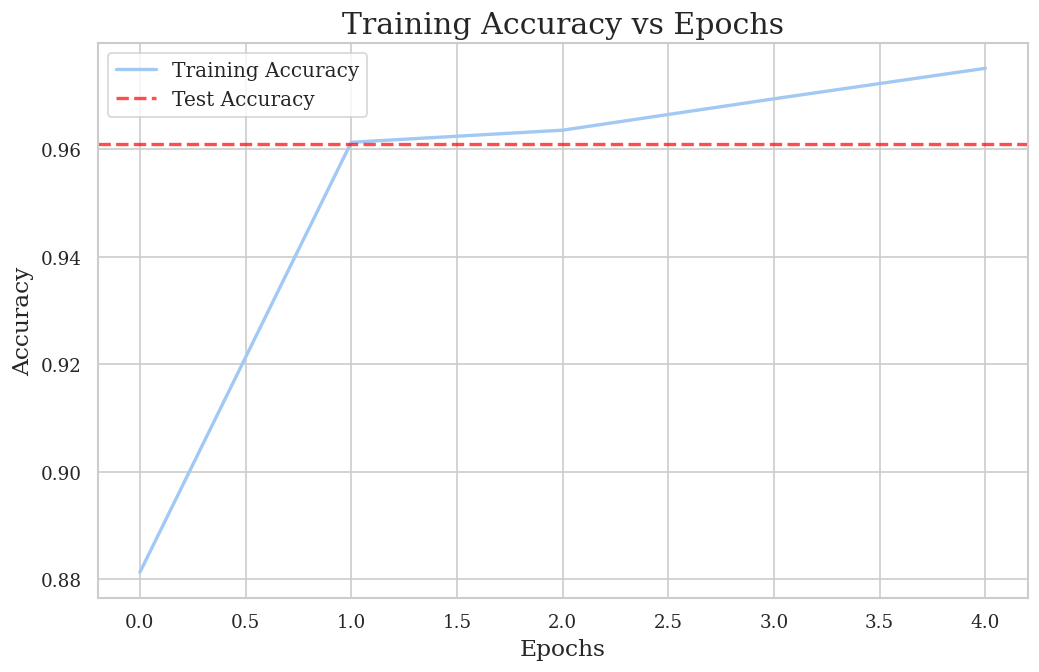

In [348]:
print(acc)
# Set the style, color palette, and font style
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.rcParams["font.family"] = "serif"

# Create a larger figure with higher DPI
plt.figure(figsize=(10, 6), dpi=120)

# Create the plot and adjust line styles
plt.plot(acc, label='Training Accuracy', linestyle='-', linewidth=2)
plt.axhline(y=test_acc_cnn, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Test Accuracy')

# Set title, labels, and legend
plt.title('Training Accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)

# Show the plot
plt.show()


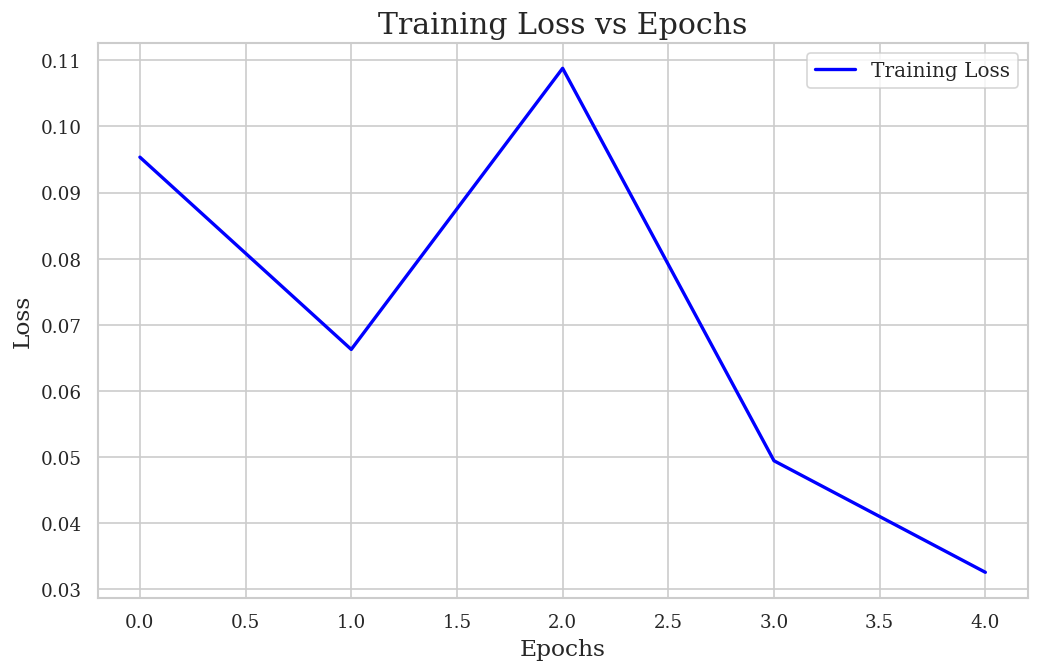

In [349]:


# Set the style, color palette, and font style
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.rcParams["font.family"] = "serif"

# Create a larger figure with higher DPI
plt.figure(figsize=(10, 6), dpi=120)

# Create the plot and adjust line styles
plt.plot(losses, label='Training Loss', linestyle='-', linewidth=2, color='blue')

# Set title, labels, and legend
plt.title('Training Loss vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

# Show the plot
plt.show()


Rate coding


In [304]:
class CustomTensorDataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list

    def __getitem__(self, index):
        return self.data_list[index], self.target_list[index]

    def __len__(self):
        return len(self.data_list)

# Use your lists of tensors to create a Dataset
num_steps =150
train_event = []
train_target = []
test_event = []
test_target = []
for i, (data, target) in enumerate(iter(train_loader)):
    train_spike_data = spikegen.rate(data,num_steps=num_steps)
    target = target.unsqueeze(0).expand(num_steps, -1)
    train_event.append(train_spike_data)
    train_target.append(target)
for i, (data, target) in enumerate(iter(test_loader)):
    test_spike_data = spikegen.rate(data,num_steps=num_steps)
    target = target.unsqueeze(0).expand(num_steps, -1)
    test_event.append(test_spike_data)
    test_target.append(target)
train_event.pop()
train_target.pop()
test_event.pop()
test_target.pop()
train_event = torch.stack(train_event)
test_event = torch.stack(test_event)
train_target = torch.stack(train_target)
test_target = torch.stack(test_target)
train_data = CustomTensorDataset(train_event, train_target)
test_data = CustomTensorDataset(test_event, test_target)
final_train_loader = DataLoader(train_data, batch_size = 1,shuffle=True)
final_test_loader = DataLoader(test_data, batch_size = 1,shuffle=True)
print(len(final_train_loader))

93


dataset for CNN

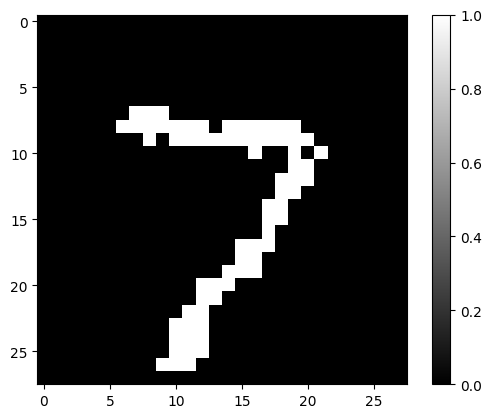

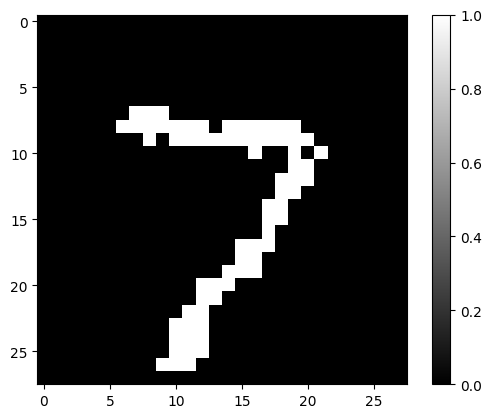

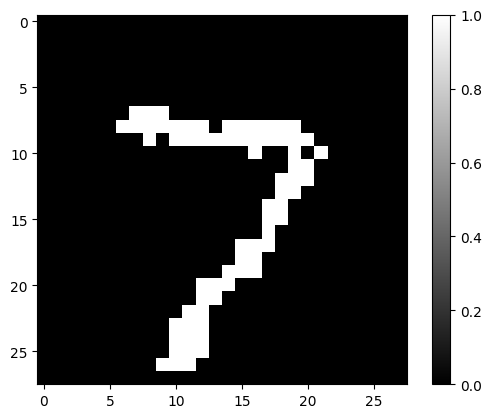

In [306]:
for i in range(3):
    plt.imshow(spike_image1, cmap='gray')
    plt.colorbar()
    plt.show()

build network

In [307]:
spike_grad = surrogate.atan()
beta = 0.1

#Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, learn_beta=True)
                    ).to(device)
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

net.apply(weight_reset)

Sequential(
  (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): Leaky()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): Leaky()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=10, bias=True)
  (8): Leaky()
)

In [308]:
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net
  
  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [309]:
learning_rate_snn = 2e-2
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate_snn, weight_decay=weight_decay_snn, momentum=0.9)

loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [310]:
def val_accuracy(net, data, label):
    net.eval()
    accur_list = []
    with torch.no_grad():
        for data, labels in zip(data, label):
            data = data
            labels = labels
            data = data.to(device)
            labels = labels.to(device)
            output = forward_pass(net, data)
            accur = SF.accuracy_rate(output, labels[0])
            accur_list.append(accur)


    return sum(accur_list)/len(accur_list)
def test_accuracy(net, dataloader):
    net.eval()
    accur_list = []
    with torch.no_grad():
        for data, labels in iter(dataloader):
            data = data[0]
            labels = labels[0]
            data = data.to(device)
            labels = labels.to(device)
            output = forward_pass(net, data)
            accur = SF.accuracy_rate(output, labels[0])
            accur_list.append(accur)


    return sum(accur_list)/len(accur_list)

In [311]:
learning_rate = 0.011
optimizer2 = torch.optim.Adamax(net.parameters(), lr=learning_rate_snn, betas=(0.9, 0.999))
optimizer1 = torch.optim.Adam(net.parameters(), lr=learning_rate_snn, betas=(0.9, 0.999))
optimizer3 = torch.optim.NAdam(net.parameters(), lr=learning_rate_snn, betas=(0.9, 0.999))
optimizers = [optimizer1, optimizer2, optimizer3]
learning_rates = [0.011, 0.012, 0.013, 0.2, 0.4, 0.6]
# for l in optimizers:
net.apply(weight_reset)
optimizer = torch.optim.Adamax(net.parameters(), lr=learning_rate_snn, betas=(0.9, 0.999))
num_epochs_snn = 5
loss_hist = []
acc_hist = []
val_acc_list = []
validation_iter = len(final_train_loader)-int(len(final_train_loader)*0.1)
print(validation_iter)
# training loop
for epoch in range(num_epochs_snn):
    for i, (data, targets) in enumerate(iter(final_train_loader)):
        if i < validation_iter:
            data = data[0]
            targets = targets[0]
            net.train()
            data = data.to(device)
            targets= targets[0] #set the target to be int rather than list
            targets = targets.to(device)
            net.train()
            spk_rec = forward_pass(net, data)
            loss_val = loss_fn(spk_rec, targets)
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
            print(f"Epoch {epoch}, Iteration {i} \n Train Loss: {loss_val.item():.2f}%\n")
            acc = SF.accuracy_rate(spk_rec, targets)
            acc_hist.append(acc)
        else:
            validation_accuracy = val_accuracy(net, data, targets)
            val_acc_list.append(validation_accuracy)
            print(f"validation accuracy: {validation_accuracy*100:.2f}%\n")
        print(f"Accuracy: {acc * 100:.2f}%\n")
test_acc = test_accuracy(net, final_test_loader)
testing_accuracy.append((str(l),test_acc))


84
Epoch 0, Iteration 0 
 Train Loss: 15.00%

Accuracy: 10.16%

Epoch 0, Iteration 1 
 Train Loss: 15.00%

Accuracy: 7.81%

Epoch 0, Iteration 2 
 Train Loss: 11.94%

Accuracy: 10.16%

Epoch 0, Iteration 3 
 Train Loss: 13.52%

Accuracy: 10.94%

Epoch 0, Iteration 4 
 Train Loss: 12.89%

Accuracy: 14.06%

Epoch 0, Iteration 5 
 Train Loss: 10.92%

Accuracy: 9.38%

Epoch 0, Iteration 6 
 Train Loss: 11.86%

Accuracy: 28.91%

Epoch 0, Iteration 7 
 Train Loss: 8.69%

Accuracy: 29.69%

Epoch 0, Iteration 8 
 Train Loss: 9.64%

Accuracy: 27.34%

Epoch 0, Iteration 9 
 Train Loss: 12.02%

Accuracy: 24.22%

Epoch 0, Iteration 10 
 Train Loss: 8.62%

Accuracy: 36.72%

Epoch 0, Iteration 11 
 Train Loss: 7.45%

Accuracy: 42.19%

Epoch 0, Iteration 12 
 Train Loss: 7.62%

Accuracy: 35.16%

Epoch 0, Iteration 13 
 Train Loss: 7.68%

Accuracy: 27.34%

Epoch 0, Iteration 14 
 Train Loss: 7.20%

Accuracy: 35.94%

Epoch 0, Iteration 15 
 Train Loss: 7.21%

Accuracy: 25.78%

Epoch 0, Iteration 16 
 T

Epoch 1, Iteration 44 
 Train Loss: 1.57%

Accuracy: 94.53%

Epoch 1, Iteration 45 
 Train Loss: 1.43%

Accuracy: 95.31%

Epoch 1, Iteration 46 
 Train Loss: 1.44%

Accuracy: 93.75%

Epoch 1, Iteration 47 
 Train Loss: 1.47%

Accuracy: 94.53%

Epoch 1, Iteration 48 
 Train Loss: 1.42%

Accuracy: 92.97%

Epoch 1, Iteration 49 
 Train Loss: 1.39%

Accuracy: 92.97%

Epoch 1, Iteration 50 
 Train Loss: 1.55%

Accuracy: 92.19%

Epoch 1, Iteration 51 
 Train Loss: 1.42%

Accuracy: 91.41%

Epoch 1, Iteration 52 
 Train Loss: 1.36%

Accuracy: 94.53%

Epoch 1, Iteration 53 
 Train Loss: 1.13%

Accuracy: 95.31%

Epoch 1, Iteration 54 
 Train Loss: 1.33%

Accuracy: 91.41%

Epoch 1, Iteration 55 
 Train Loss: 1.45%

Accuracy: 93.75%

Epoch 1, Iteration 56 
 Train Loss: 1.41%

Accuracy: 93.75%

Epoch 1, Iteration 57 
 Train Loss: 1.39%

Accuracy: 94.53%

Epoch 1, Iteration 58 
 Train Loss: 1.40%

Accuracy: 92.97%

Epoch 1, Iteration 59 
 Train Loss: 1.66%

Accuracy: 89.06%

Epoch 1, Iteration 60 
 

validation accuracy: 95.31%

Accuracy: 96.88%

validation accuracy: 90.62%

Accuracy: 96.88%

validation accuracy: 97.66%

Accuracy: 96.88%

validation accuracy: 97.66%

Accuracy: 96.88%

Epoch 3, Iteration 0 
 Train Loss: 1.17%

Accuracy: 95.31%

Epoch 3, Iteration 1 
 Train Loss: 1.12%

Accuracy: 92.97%

Epoch 3, Iteration 2 
 Train Loss: 1.00%

Accuracy: 94.53%

Epoch 3, Iteration 3 
 Train Loss: 0.95%

Accuracy: 96.88%

Epoch 3, Iteration 4 
 Train Loss: 1.03%

Accuracy: 95.31%

Epoch 3, Iteration 5 
 Train Loss: 1.22%

Accuracy: 91.41%

Epoch 3, Iteration 6 
 Train Loss: 1.23%

Accuracy: 97.66%

Epoch 3, Iteration 7 
 Train Loss: 1.27%

Accuracy: 89.84%

Epoch 3, Iteration 8 
 Train Loss: 1.14%

Accuracy: 95.31%

Epoch 3, Iteration 9 
 Train Loss: 1.23%

Accuracy: 95.31%

Epoch 3, Iteration 10 
 Train Loss: 0.99%

Accuracy: 96.88%

Epoch 3, Iteration 11 
 Train Loss: 1.17%

Accuracy: 96.09%

Epoch 3, Iteration 12 
 Train Loss: 0.95%

Accuracy: 96.88%

Epoch 3, Iteration 13 
 Train

Epoch 4, Iteration 41 
 Train Loss: 0.84%

Accuracy: 95.31%

Epoch 4, Iteration 42 
 Train Loss: 0.84%

Accuracy: 97.66%

Epoch 4, Iteration 43 
 Train Loss: 1.08%

Accuracy: 93.75%

Epoch 4, Iteration 44 
 Train Loss: 0.88%

Accuracy: 96.88%

Epoch 4, Iteration 45 
 Train Loss: 1.24%

Accuracy: 90.62%

Epoch 4, Iteration 46 
 Train Loss: 0.92%

Accuracy: 96.88%

Epoch 4, Iteration 47 
 Train Loss: 0.94%

Accuracy: 96.09%

Epoch 4, Iteration 48 
 Train Loss: 1.08%

Accuracy: 94.53%

Epoch 4, Iteration 49 
 Train Loss: 0.79%

Accuracy: 98.44%

Epoch 4, Iteration 50 
 Train Loss: 0.88%

Accuracy: 95.31%

Epoch 4, Iteration 51 
 Train Loss: 0.92%

Accuracy: 96.09%

Epoch 4, Iteration 52 
 Train Loss: 0.80%

Accuracy: 98.44%

Epoch 4, Iteration 53 
 Train Loss: 0.94%

Accuracy: 94.53%

Epoch 4, Iteration 54 
 Train Loss: 0.91%

Accuracy: 96.88%

Epoch 4, Iteration 55 
 Train Loss: 1.28%

Accuracy: 92.19%

Epoch 4, Iteration 56 
 Train Loss: 0.79%

Accuracy: 97.66%

Epoch 4, Iteration 57 
 

In [312]:
print(test_acc)

0.946875


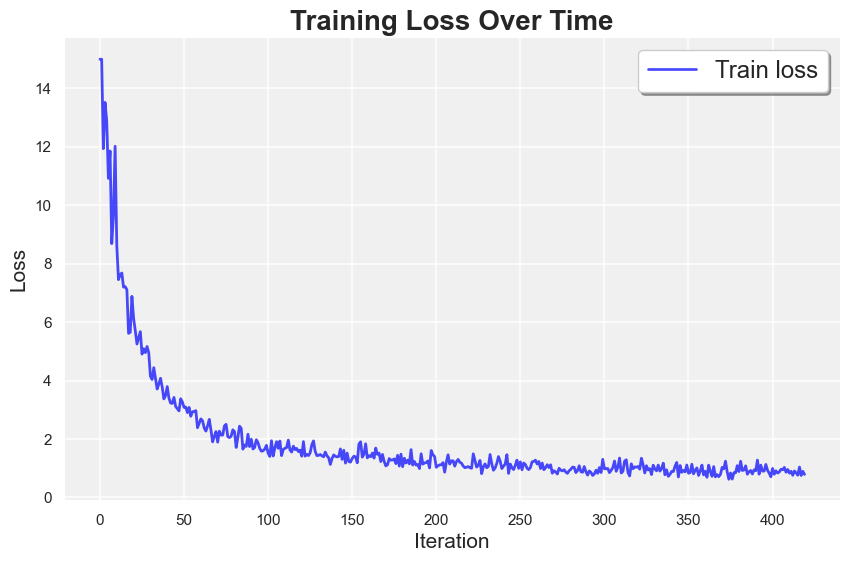

In [313]:
# plt.plot(loss_hist, color='b', label='train loss')
import seaborn as sns
from matplotlib.ticker import MaxNLocator
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
# Plot loss history
ax.plot(loss_hist, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Train loss')
# Add legend
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
# Set the title
ax.set_title('Training Loss Over Time', fontsize=20, fontweight='bold')
# Set x and y labels
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
# Force x-axis to display integer labels
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# Set background color for the plot
ax.set_facecolor('#f0f0f0')
# Enhance grid line style
ax.grid(color='white', linestyle='-', linewidth=1.5)
# Remove axis splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Display the plot
plt.show()


testing set


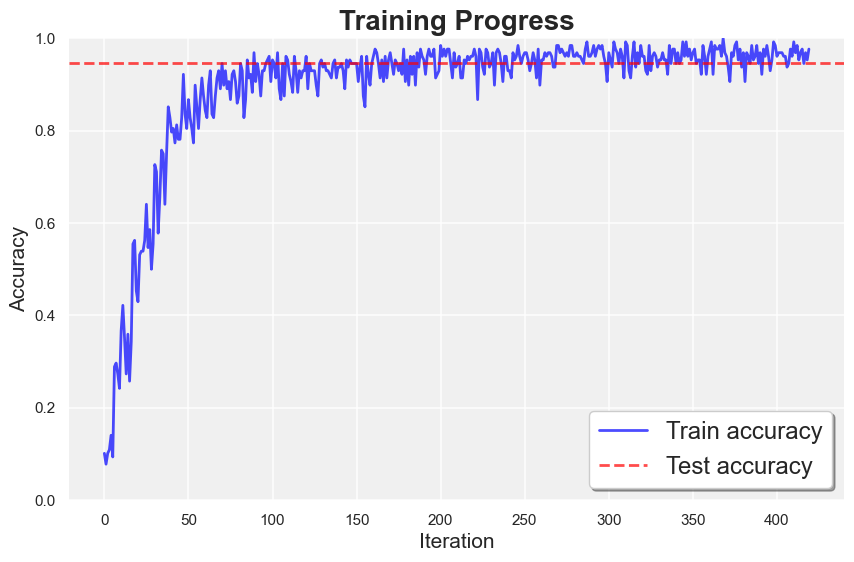

In [316]:
# test_acc = test_accuracy(net, final_test_loader)
# fig = plt.figure(facecolor='w')
# plt.axhline(y=test_accuracy, color='r', linestyle='--',label='test accuracy')
# plt.plot(acc_hist)
# plt.plot(val_acc_list, color='g', label='val accuracy')
# plt.title('train set accuracy')
# plt.xlabel("iteration")
# plt.ylabel('accuracy')
# plt.legend()
# plt.show
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
# Plot accuracy history
ax.plot(acc_hist, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Train accuracy')
# Plot validation accuracy
# ax.plot(val_acc_list, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Validation accuracy')
# Plot test accuracy as horizontal line
ax.axhline(y=test_acc, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Test accuracy')
# Add legend
legend = plt.legend(loc='lower right', shadow=True, fontsize='x-large')
# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
# Set the title
ax.set_title('Training Progress', fontsize=20, fontweight='bold')
# Set x and y labels
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
# Set y-axis limits
ax.set_ylim([0, 1])
# Force x-axis to display integer labels
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# Set background color for the plot
ax.set_facecolor('#f0f0f0')
# Enhance grid line style
ax.grid(color='white', linestyle='-', linewidth=1.5)
# Remove axis splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Display the plot
plt.show()

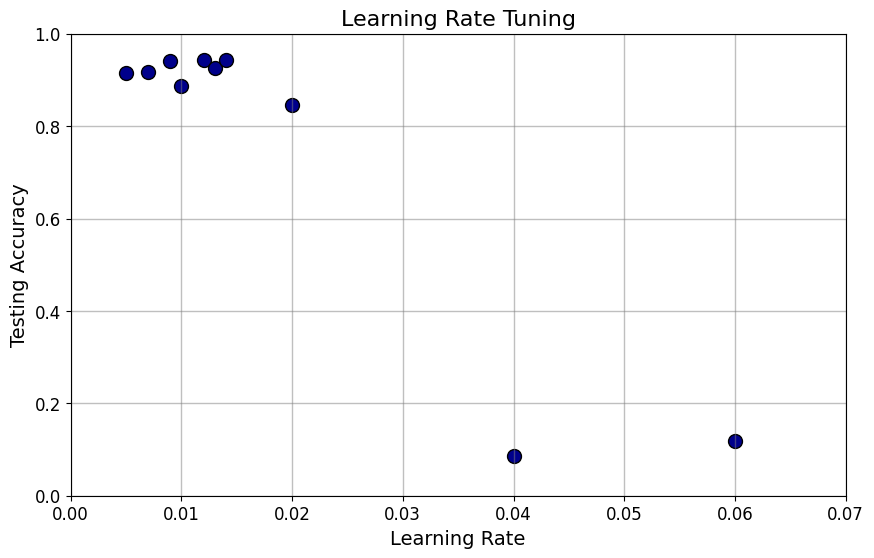

In [231]:
lr = [0.005, 0.007, 0.009, 0.01, 0.012, 0.013, 0.014, 0.02,0.04, 0.06]
acc=[0.9156,0.9182,0.9406,0.8875,0.9432,0.9265,0.9421,0.8463,0.08645,0.11875]

# Create a new figure with a specific size (optional)
plt.figure(figsize=(10, 6))

# Scatter plot data with specific marker style and color
plt.scatter(lr, acc, marker='o', c='darkblue', edgecolors='black', s=100)

# Set the title and labels with a larger font size
plt.title('Learning Rate Tuning', fontsize=16)
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('Testing Accuracy', fontsize=14)

# Set the limit for x and y axis (optional)
plt.xlim([0, 0.07])
plt.ylim([0, 1.0])

# Add minor gridlines to the plot
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Add major gridlines to the plot
plt.grid(which='major', color='gray', linestyle='-', linewidth=1)

# Set the tick label size
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

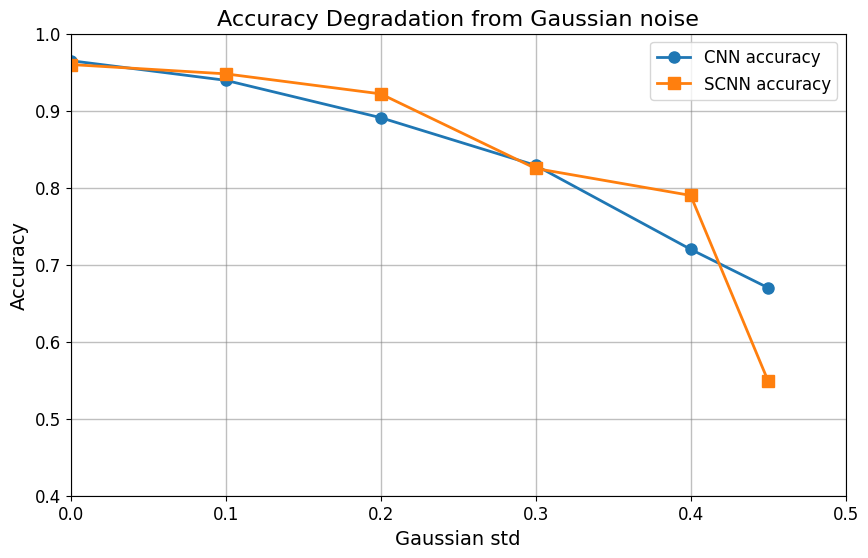

In [289]:
# noise = [0, 0.1, 0.2, 0.3,0.4,0.45]
# acccnn = [0.965,0.9395,0.891,0.829,0.72,0.67]
# accscnn=[0.96,0.9479,0.9219,0.825,0.79,0.5489]

# # Create a new figure with a specific size (optional)
# plt.figure(figsize=(10, 6))

# # Plot data with specific line styles and markers
# plt.plot(noise, acccnn, 'o-', linewidth=2, markersize=8, label='CNN accuracy')
# plt.plot(noise, accscnn, 's-', linewidth=2, markersize=8, label='SCNN accuracy')

# # Set the title and labels with a larger font size
# plt.title('Accuracy Degradation from Gaussian noise', fontsize=16)
# plt.xlabel('Gaussian std', fontsize=14)
# plt.ylabel('Accuracy', fontsize=14)

# # Set the limit for x and y axis (optional)
# plt.xlim([0, 0.5])
# plt.ylim([0.4, 1.0])

# # Add minor gridlines to the plot
# plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# # Add major gridlines to the plot
# plt.grid(which='major', color='gray', linestyle='-', linewidth=1)

# # Set the tick label size
# plt.tick_params(axis='both', which='major', labelsize=12)

# # Add the legend with a larger font size
# plt.legend(fontsize=12)

# # Show the plot
# plt.show()

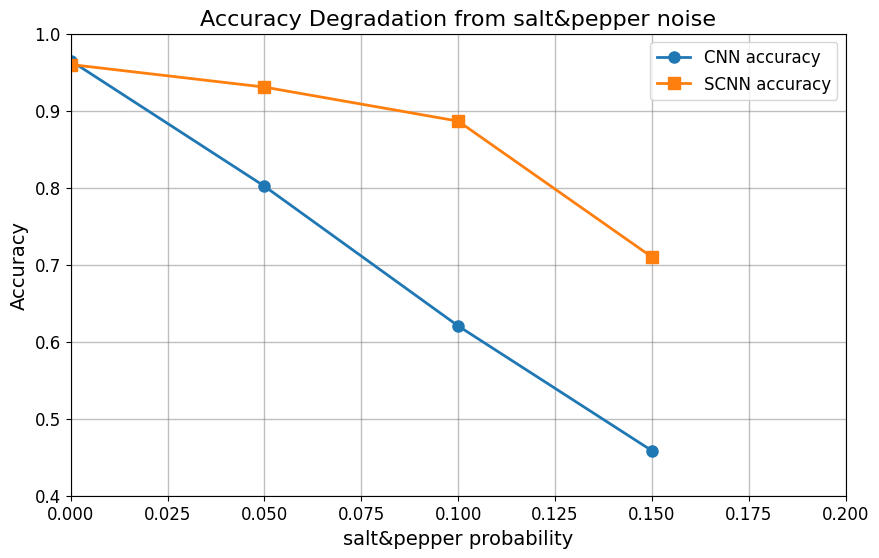

In [293]:
noise = [0,0.05,0.1,0.15]
acccnn = [0.965,0.802,0.6205,0.4585]
accscnn=[0.96,0.9307,0.8865,0.71]

# Create a new figure with a specific size (optional)
plt.figure(figsize=(10, 6))

# Plot data with specific line styles and markers
plt.plot(noise, acccnn, 'o-', linewidth=2, markersize=8, label='CNN accuracy')
plt.plot(noise, accscnn, 's-', linewidth=2, markersize=8, label='SCNN accuracy')

# Set the title and labels with a larger font size
plt.title('Accuracy Degradation from salt&pepper noise', fontsize=16)
plt.xlabel('salt&pepper probability', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Set the limit for x and y axis (optional)
plt.xlim([0, 0.2])
plt.ylim([0.4, 1.0])

# Add minor gridlines to the plot
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Add major gridlines to the plot
plt.grid(which='major', color='gray', linestyle='-', linewidth=1)

# Set the tick label size
plt.tick_params(axis='both', which='major', labelsize=12)

# Add the legend with a larger font size
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [294]:
from scipy import stats

# acccnn and accscnn should be lists of accuracies for each noise level
t_statistic, p_value = stats.ttest_rel(acccnn, accscnn)


print("p-value:", p_value)


p-value: 0.08471446983050067
